In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

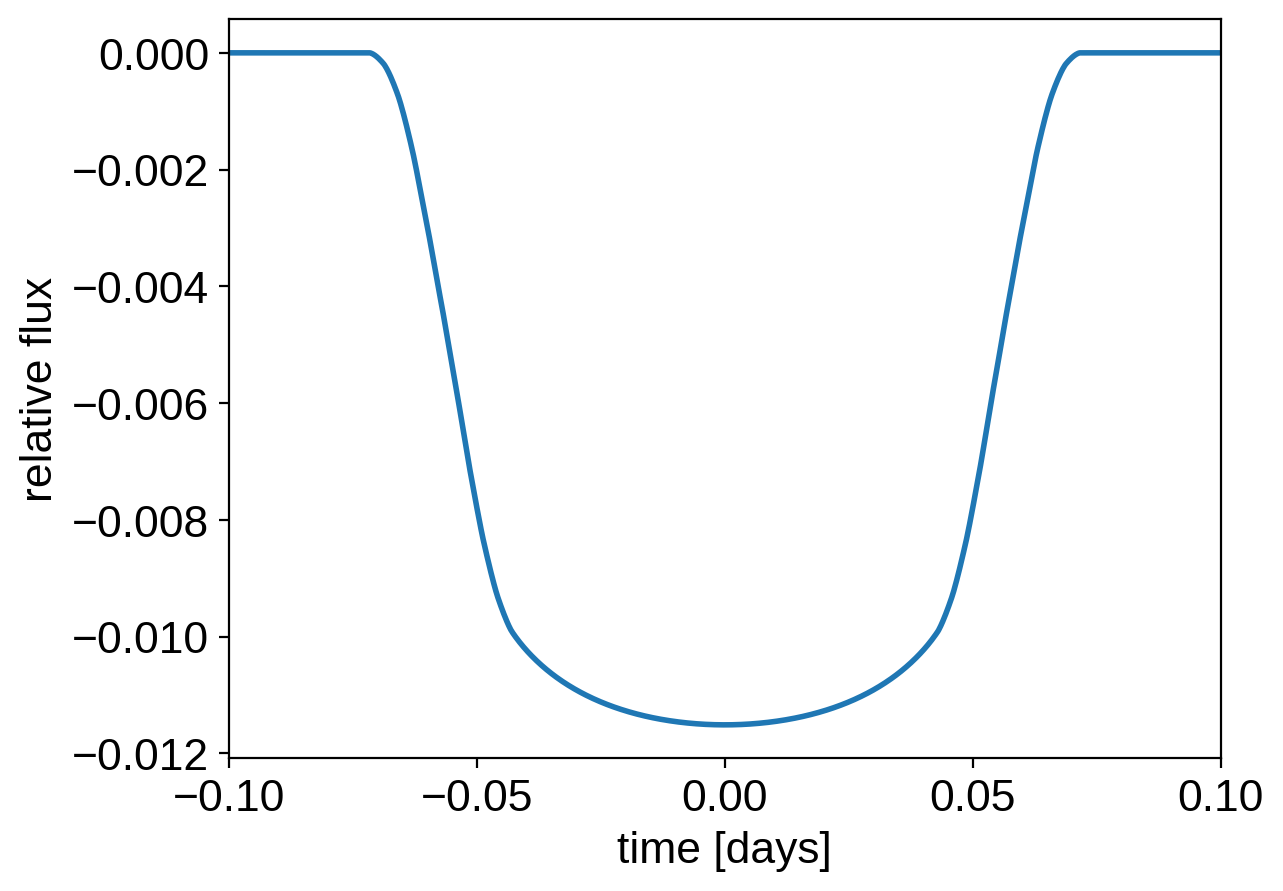

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.478798e+04]

1it [00:00, 272.34it/s, logp=2.478798e+04]

2it [00:00, 364.01it/s, logp=-4.973052e+09]

3it [00:00, 430.05it/s, logp=2.478859e+04] 

4it [00:00, 464.82it/s, logp=2.478913e+04]

5it [00:00, 486.22it/s, logp=2.478977e+04]

6it [00:00, 508.37it/s, logp=2.479074e+04]

7it [00:00, 523.48it/s, logp=2.478483e+04]

8it [00:00, 529.72it/s, logp=2.479082e+04]

9it [00:00, 541.92it/s, logp=2.479098e+04]

10it [00:00, 551.36it/s, logp=2.479151e+04]

11it [00:00, 555.48it/s, logp=2.479065e+04]

12it [00:00, 561.39it/s, logp=2.479174e+04]

13it [00:00, 567.08it/s, logp=2.479145e+04]

14it [00:00, 576.61it/s, logp=2.479182e+04]

15it [00:00, 577.03it/s, logp=2.479195e+04]

16it [00:00, 584.28it/s, logp=2.479239e+04]

17it [00:00, 588.05it/s, logp=2.479094e+04]

18it [00:00, 594.60it/s, logp=2.479253e+04]

19it [00:00, 593.75it/s, logp=2.479279e+04]

20it [00:00, 597.04it/s, logp=2.479323e+04]

21it [00:00, 600.62it/s, logp=2.479351e+04]

22it [00:00, 598.86it/s, logp=2.479354e+04]

23it [00:00, 601.04it/s, logp=2.479354e+04]

24it [00:00, 601.96it/s, logp=2.479354e+04]

25it [00:00, 601.96it/s, logp=2.479354e+04]

26it [00:00, 606.09it/s, logp=2.479354e+04]

27it [00:00, 606.09it/s, logp=2.479354e+04]

28it [00:00, 605.74it/s, logp=2.479354e+04]

29it [00:00, 607.16it/s, logp=2.479354e+04]

30it [00:00, 607.58it/s, logp=2.479354e+04]

31it [00:00, 609.16it/s, logp=2.479354e+04]

32it [00:00, 610.61it/s, logp=2.479354e+04]

33it [00:00, 612.49it/s, logp=2.479354e+04]

34it [00:00, 615.29it/s, logp=2.479354e+04]

35it [00:00, 618.26it/s, logp=2.479354e+04]

36it [00:00, 616.92it/s, logp=2.479354e+04]

37it [00:00, 617.58it/s, logp=2.479354e+04]

38it [00:00, 618.96it/s, logp=2.479354e+04]

39it [00:00, 621.27it/s, logp=2.479354e+04]

40it [00:00, 623.77it/s, logp=2.479354e+04]

41it [00:00, 626.22it/s, logp=2.479354e+04]

42it [00:00, 627.83it/s, logp=2.479354e+04]

43it [00:00, 626.42it/s, logp=2.479354e+04]

44it [00:00, 625.40it/s, logp=2.479354e+04]

45it [00:00, 626.64it/s, logp=2.479354e+04]

46it [00:00, 627.89it/s, logp=2.479354e+04]

47it [00:00, 627.15it/s, logp=2.479354e+04]

48it [00:00, 629.26it/s, logp=2.479354e+04]

49it [00:00, 630.74it/s, logp=2.479354e+04]

50it [00:00, 630.20it/s, logp=2.479354e+04]

51it [00:00, 631.28it/s, logp=2.479354e+04]

52it [00:00, 630.94it/s, logp=2.479354e+04]

53it [00:00, 631.34it/s, logp=2.479354e+04]

54it [00:00, 632.87it/s, logp=2.479354e+04]

55it [00:00, 633.66it/s, logp=2.479354e+04]

56it [00:00, 634.53it/s, logp=2.479354e+04]

57it [00:00, 635.46it/s, logp=2.479354e+04]

58it [00:00, 636.76it/s, logp=2.479354e+04]

59it [00:00, 638.39it/s, logp=2.479354e+04]

60it [00:00, 639.62it/s, logp=2.479354e+04]

61it [00:00, 641.03it/s, logp=2.479354e+04]

62it [00:00, 640.30it/s, logp=2.479354e+04]

63it [00:00, 640.73it/s, logp=2.479354e+04]

64it [00:00, 640.99it/s, logp=2.479354e+04]

65it [00:00, 647.97it/s, logp=2.479354e+04]

65it [00:00, 647.97it/s, logp=2.479354e+04]

66it [00:00, 647.97it/s, logp=2.479354e+04]

67it [00:00, 647.97it/s, logp=2.479354e+04]

68it [00:00, 647.97it/s, logp=2.479354e+04]

69it [00:00, 647.97it/s, logp=2.479354e+04]

70it [00:00, 647.97it/s, logp=2.479354e+04]

71it [00:00, 647.97it/s, logp=2.479354e+04]

72it [00:00, 647.97it/s, logp=2.479354e+04]

73it [00:00, 647.97it/s, logp=2.479354e+04]

74it [00:00, 647.97it/s, logp=2.479354e+04]

75it [00:00, 647.97it/s, logp=2.479354e+04]

76it [00:00, 647.97it/s, logp=2.479354e+04]

77it [00:00, 647.97it/s, logp=2.479354e+04]

78it [00:00, 647.97it/s, logp=2.479354e+04]

79it [00:00, 647.97it/s, logp=2.479354e+04]

80it [00:00, 647.97it/s, logp=2.479354e+04]

81it [00:00, 647.97it/s, logp=2.479354e+04]

82it [00:00, 647.97it/s, logp=2.479354e+04]

83it [00:00, 647.97it/s, logp=2.479354e+04]

84it [00:00, 647.97it/s, logp=2.479354e+04]

85it [00:00, 647.97it/s, logp=2.479354e+04]

86it [00:00, 647.97it/s, logp=2.479354e+04]

87it [00:00, 647.97it/s, logp=2.479354e+04]

88it [00:00, 647.97it/s, logp=2.479354e+04]

89it [00:00, 647.97it/s, logp=2.479354e+04]

90it [00:00, 647.97it/s, logp=2.479354e+04]

91it [00:00, 647.97it/s, logp=2.479354e+04]

92it [00:00, 647.97it/s, logp=2.479354e+04]

93it [00:00, 647.97it/s, logp=2.479354e+04]

94it [00:00, 647.97it/s, logp=2.479354e+04]

95it [00:00, 647.97it/s, logp=2.479354e+04]

96it [00:00, 647.97it/s, logp=2.479354e+04]

97it [00:00, 647.97it/s, logp=2.479354e+04]

98it [00:00, 647.97it/s, logp=2.479354e+04]

99it [00:00, 647.97it/s, logp=2.479354e+04]

100it [00:06, 15.76it/s, logp=2.479354e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.53942561119


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

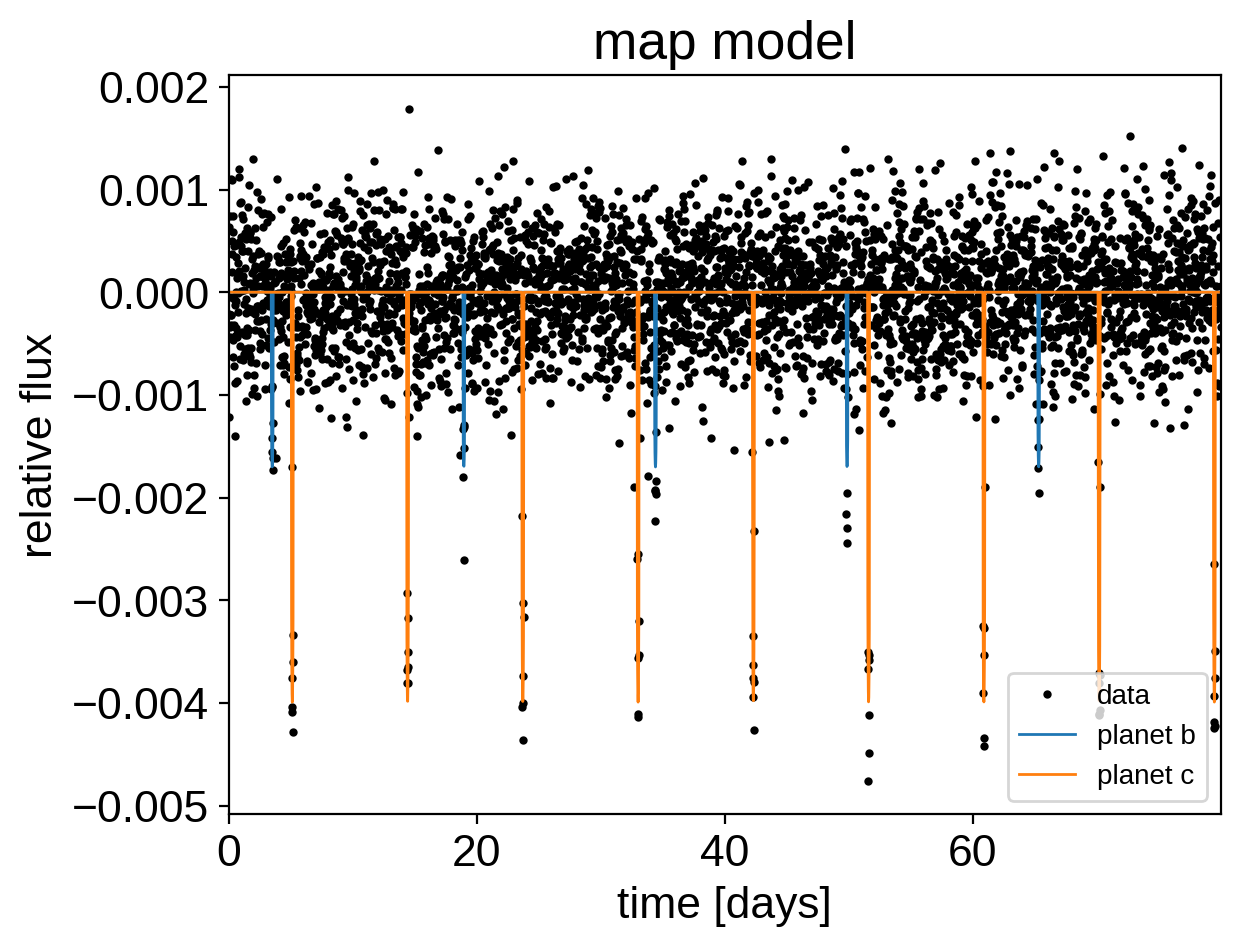

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/12000 [00:00<03:33, 56.24draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/12000 [00:00<07:53, 25.32draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/12000 [00:00<10:58, 18.19draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/12000 [00:00<13:00, 15.36draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/12000 [00:00<14:38, 13.64draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/12000 [00:01<15:33, 12.83draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/12000 [00:01<16:02, 12.44draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/12000 [00:01<16:34, 12.04draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/12000 [00:01<16:53, 11.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/12000 [00:01<17:10, 11.61draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/12000 [00:01<17:23, 11.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/12000 [00:02<15:58, 12.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/12000 [00:02<16:55, 11.79draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/12000 [00:02<18:05, 11.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 40/12000 [00:02<18:10, 10.96draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 42/12000 [00:02<18:19, 10.87draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/12000 [00:03<18:07, 11.00draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/12000 [00:03<17:59, 11.08draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 48/12000 [00:03<17:54, 11.12draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 50/12000 [00:03<17:46, 11.21draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 52/12000 [00:03<17:57, 11.08draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 54/12000 [00:04<18:08, 10.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 56/12000 [00:04<18:04, 11.02draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/12000 [00:04<17:53, 11.12draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 60/12000 [00:04<17:47, 11.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 62/12000 [00:04<17:56, 11.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 64/12000 [00:04<17:57, 11.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 66/12000 [00:05<17:52, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 68/12000 [00:05<18:19, 10.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 70/12000 [00:05<18:09, 10.95draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 72/12000 [00:05<17:54, 11.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 74/12000 [00:05<17:51, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 76/12000 [00:06<17:49, 11.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 78/12000 [00:06<17:53, 11.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 80/12000 [00:06<17:54, 11.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 82/12000 [00:06<17:50, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 84/12000 [00:06<18:03, 11.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 86/12000 [00:06<17:52, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 88/12000 [00:07<17:49, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 90/12000 [00:07<18:02, 11.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 92/12000 [00:07<17:53, 11.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/12000 [00:07<17:51, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 96/12000 [00:07<17:39, 11.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/12000 [00:07<17:42, 11.20draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 100/12000 [00:08<17:35, 11.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/12000 [00:08<18:10, 10.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/12000 [00:08<18:04, 10.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/12000 [00:08<18:01, 11.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/12000 [00:08<17:48, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 110/12000 [00:09<17:47, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 112/12000 [00:09<17:40, 11.21draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 114/12000 [00:09<17:33, 11.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 116/12000 [00:09<17:31, 11.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 118/12000 [00:09<17:34, 11.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 120/12000 [00:09<17:32, 11.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/12000 [00:10<17:40, 11.20draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 124/12000 [00:10<17:37, 11.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 126/12000 [00:10<17:31, 11.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/12000 [00:10<16:14, 12.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 130/12000 [00:10<16:33, 11.95draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 132/12000 [00:10<16:53, 11.71draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/12000 [00:11<17:30, 11.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 136/12000 [00:11<17:33, 11.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/12000 [00:11<17:26, 11.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/12000 [00:11<17:23, 11.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 142/12000 [00:11<17:18, 11.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 144/12000 [00:12<17:21, 11.39draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 146/12000 [00:12<17:18, 11.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 148/12000 [00:12<17:16, 11.44draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 150/12000 [00:12<17:25, 11.33draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 152/12000 [00:12<17:29, 11.29draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 154/12000 [00:12<17:38, 11.19draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 156/12000 [00:13<17:51, 11.05draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 158/12000 [00:13<15:54, 12.41draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 160/12000 [00:13<16:28, 11.97draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 162/12000 [00:13<16:45, 11.78draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 164/12000 [00:13<16:55, 11.65draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 166/12000 [00:13<17:03, 11.57draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 168/12000 [00:14<17:12, 11.46draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 170/12000 [00:14<17:16, 11.42draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 172/12000 [00:14<18:06, 10.89draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 174/12000 [00:14<18:01, 10.94draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 176/12000 [00:14<17:48, 11.06draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 178/12000 [00:15<17:38, 11.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 180/12000 [00:15<17:33, 11.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 182/12000 [00:15<17:24, 11.31draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 184/12000 [00:15<17:21, 11.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 186/12000 [00:15<17:25, 11.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 188/12000 [00:15<17:18, 11.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 190/12000 [00:16<17:21, 11.33draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 192/12000 [00:16<17:20, 11.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 194/12000 [00:16<17:46, 11.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 196/12000 [00:16<18:02, 10.91draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 198/12000 [00:16<17:45, 11.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 200/12000 [00:16<17:37, 11.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 202/12000 [00:17<17:32, 11.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 204/12000 [00:17<17:28, 11.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 206/12000 [00:17<18:10, 10.82draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 208/12000 [00:17<18:19, 10.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 210/12000 [00:17<18:06, 10.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 212/12000 [00:18<17:48, 11.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 214/12000 [00:18<17:41, 11.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 216/12000 [00:18<17:33, 11.18draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 218/12000 [00:18<17:34, 11.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 220/12000 [00:18<17:27, 11.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 222/12000 [00:18<17:22, 11.30draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 224/12000 [00:19<17:29, 11.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 226/12000 [00:19<17:31, 11.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 228/12000 [00:19<17:35, 11.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 230/12000 [00:19<17:41, 11.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 232/12000 [00:19<17:40, 11.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 234/12000 [00:20<17:30, 11.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 236/12000 [00:20<17:34, 11.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 238/12000 [00:20<17:31, 11.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 240/12000 [00:20<18:15, 10.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 242/12000 [00:20<18:13, 10.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 244/12000 [00:20<18:21, 10.68draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 246/12000 [00:21<18:24, 10.64draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 248/12000 [00:21<18:10, 10.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 250/12000 [00:21<18:08, 10.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 252/12000 [00:21<18:19, 10.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 254/12000 [00:21<18:30, 10.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 256/12000 [00:22<18:31, 10.56draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 258/12000 [00:22<18:30, 10.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 260/12000 [00:22<18:28, 10.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 262/12000 [00:22<18:24, 10.63draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 264/12000 [00:22<18:17, 10.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 266/12000 [00:23<18:31, 10.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 268/12000 [00:23<18:27, 10.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 270/12000 [00:23<18:14, 10.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 272/12000 [00:23<18:45, 10.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 274/12000 [00:23<18:27, 10.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 276/12000 [00:23<18:08, 10.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 278/12000 [00:24<17:55, 10.90draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 280/12000 [00:24<18:06, 10.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 282/12000 [00:24<17:59, 10.85draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 284/12000 [00:24<18:07, 10.77draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 286/12000 [00:24<18:08, 10.76draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 288/12000 [00:25<18:01, 10.83draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 291/12000 [00:25<16:16, 11.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/12000 [00:25<16:51, 11.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 296/12000 [00:25<16:00, 12.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 298/12000 [00:25<14:39, 13.31draws/s]

Sampling 2 chains, 0 divergences:   2%|▎         | 300/12000 [00:26<15:42, 12.41draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 303/12000 [00:26<13:12, 14.75draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 305/12000 [00:26<13:51, 14.06draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 307/12000 [00:26<15:11, 12.83draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 309/12000 [00:26<15:38, 12.46draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 311/12000 [00:26<16:20, 11.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 315/12000 [00:26<13:06, 14.85draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 323/12000 [00:27<09:54, 19.64draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 329/12000 [00:27<07:56, 24.49draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 335/12000 [00:27<06:35, 29.49draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 344/12000 [00:27<05:19, 36.44draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 355/12000 [00:27<04:19, 44.89draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 367/12000 [00:27<03:31, 54.97draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 377/12000 [00:27<03:06, 62.28draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 395/12000 [00:27<02:30, 77.18draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 412/12000 [00:27<02:07, 90.73draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 425/12000 [00:28<02:00, 95.68draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 440/12000 [00:28<01:49, 105.69draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 457/12000 [00:28<01:38, 117.40draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 471/12000 [00:28<01:34, 122.07draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 486/12000 [00:28<01:30, 127.43draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 503/12000 [00:28<01:23, 137.73draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 519/12000 [00:28<01:21, 141.25draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 538/12000 [00:28<01:16, 149.27draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 555/12000 [00:28<01:14, 153.55draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 572/12000 [00:28<01:13, 155.07draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 588/12000 [00:29<01:13, 155.97draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 605/12000 [00:29<01:12, 157.23draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 623/12000 [00:29<01:10, 160.50draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 640/12000 [00:29<01:09, 163.02draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 664/12000 [00:29<01:03, 178.45draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 683/12000 [00:29<01:04, 174.75draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 701/12000 [00:29<01:06, 169.80draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 719/12000 [00:29<01:12, 155.90draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 736/12000 [00:29<01:11, 157.22draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 753/12000 [00:30<01:09, 160.68draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 771/12000 [00:30<01:08, 164.44draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 791/12000 [00:30<01:04, 173.01draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 813/12000 [00:30<01:00, 184.65draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 832/12000 [00:30<01:03, 177.07draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 852/12000 [00:30<01:01, 180.78draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 873/12000 [00:30<00:59, 187.30draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 892/12000 [00:30<01:01, 181.76draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 911/12000 [00:30<01:08, 161.72draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 930/12000 [00:31<01:05, 168.01draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 949/12000 [00:31<01:04, 171.47draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 967/12000 [00:31<01:06, 166.44draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 984/12000 [00:31<01:06, 166.49draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1003/12000 [00:31<01:03, 172.00draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1021/12000 [00:31<01:05, 168.42draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1038/12000 [00:31<01:05, 168.44draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1055/12000 [00:31<01:04, 168.80draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1072/12000 [00:31<01:05, 166.17draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1089/12000 [00:32<01:07, 162.75draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1106/12000 [00:32<01:10, 154.81draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1122/12000 [00:32<01:20, 135.36draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1137/12000 [00:32<01:21, 132.70draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1154/12000 [00:32<01:16, 141.38draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1173/12000 [00:32<01:11, 152.09draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1194/12000 [00:32<01:05, 164.52draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1212/12000 [00:32<01:04, 166.10draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1230/12000 [00:32<01:03, 168.37draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1248/12000 [00:33<01:03, 170.59draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1266/12000 [00:33<01:06, 161.47draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1284/12000 [00:33<01:05, 163.97draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1302/12000 [00:33<01:03, 167.76draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1321/12000 [00:33<01:01, 173.35draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1339/12000 [00:33<01:01, 172.76draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1357/12000 [00:33<01:01, 174.47draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1375/12000 [00:33<01:01, 172.23draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1393/12000 [00:33<01:02, 169.44draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1410/12000 [00:33<01:03, 166.36draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1428/12000 [00:34<01:02, 169.99draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1446/12000 [00:34<01:01, 170.26draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1464/12000 [00:34<01:02, 169.65draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1482/12000 [00:34<01:02, 169.56draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1499/12000 [00:34<01:03, 164.97draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1516/12000 [00:34<01:06, 156.48draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1534/12000 [00:34<01:05, 160.80draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1554/12000 [00:34<01:02, 168.20draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1571/12000 [00:34<01:03, 163.77draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1588/12000 [00:35<01:02, 165.36draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1605/12000 [00:35<01:04, 162.36draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1623/12000 [00:35<01:02, 166.10draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1642/12000 [00:35<01:00, 171.91draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1660/12000 [00:35<01:03, 163.87draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1677/12000 [00:35<01:04, 160.76draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1696/12000 [00:35<01:01, 167.58draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1716/12000 [00:35<00:58, 174.58draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1734/12000 [00:35<01:01, 167.74draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1753/12000 [00:36<01:00, 169.11draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1772/12000 [00:36<00:59, 172.84draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1790/12000 [00:36<01:01, 165.48draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1807/12000 [00:36<01:04, 158.83draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1824/12000 [00:36<01:03, 161.12draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1841/12000 [00:36<01:04, 157.69draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1860/12000 [00:36<01:01, 164.33draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1878/12000 [00:36<01:01, 165.30draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1895/12000 [00:36<01:01, 163.95draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1912/12000 [00:37<01:02, 160.31draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1930/12000 [00:37<01:00, 165.73draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1947/12000 [00:37<01:00, 166.58draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1964/12000 [00:37<01:01, 164.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1981/12000 [00:37<01:01, 162.32draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1998/12000 [00:37<01:05, 151.75draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2014/12000 [00:37<01:04, 154.06draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2034/12000 [00:37<01:00, 165.17draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2051/12000 [00:37<00:59, 166.03draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2068/12000 [00:37<01:03, 155.68draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2084/12000 [00:38<01:03, 156.29draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2102/12000 [00:38<01:01, 162.14draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2121/12000 [00:38<00:58, 168.44draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2139/12000 [00:38<00:59, 166.14draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2156/12000 [00:38<00:59, 165.14draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2173/12000 [00:38<01:00, 161.66draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2190/12000 [00:38<01:00, 161.56draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2207/12000 [00:38<01:00, 160.67draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2225/12000 [00:38<01:00, 161.24draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2243/12000 [00:39<00:58, 166.28draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2262/12000 [00:39<00:56, 171.67draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2283/12000 [00:39<00:53, 180.33draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2302/12000 [00:39<00:54, 177.10draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2320/12000 [00:39<00:57, 169.05draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2338/12000 [00:39<00:57, 166.94draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2356/12000 [00:39<00:57, 167.87draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2376/12000 [00:39<00:55, 174.08draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2394/12000 [00:39<00:55, 174.61draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2412/12000 [00:40<00:57, 167.31draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2429/12000 [00:40<01:01, 155.20draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2446/12000 [00:40<01:00, 159.08draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2463/12000 [00:40<00:59, 160.45draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2480/12000 [00:40<00:59, 158.99draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2497/12000 [00:40<01:01, 154.50draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2515/12000 [00:40<00:59, 158.45draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2532/12000 [00:40<00:59, 160.27draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2550/12000 [00:40<00:57, 165.10draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2567/12000 [00:41<00:59, 158.32draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2583/12000 [00:41<01:00, 156.49draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2601/12000 [00:41<00:59, 159.11draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2618/12000 [00:41<00:57, 162.20draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2635/12000 [00:41<00:58, 160.45draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2652/12000 [00:41<00:58, 158.63draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2668/12000 [00:41<01:00, 154.23draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2684/12000 [00:41<01:00, 153.89draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2702/12000 [00:41<00:58, 157.65draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2718/12000 [00:41<01:00, 153.10draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2734/12000 [00:42<00:59, 155.03draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2750/12000 [00:42<01:00, 153.93draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2767/12000 [00:42<00:58, 157.11draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2784/12000 [00:42<00:58, 156.92draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2801/12000 [00:42<00:57, 159.24draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2817/12000 [00:42<00:58, 158.22draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 2833/12000 [00:42<00:57, 158.35draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2852/12000 [00:42<00:56, 162.17draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2869/12000 [00:42<00:55, 163.85draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2886/12000 [00:43<00:56, 160.98draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2903/12000 [00:43<00:56, 160.77draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2920/12000 [00:43<00:55, 163.31draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2937/12000 [00:43<00:55, 162.66draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2954/12000 [00:43<00:57, 158.58draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2971/12000 [00:43<00:57, 157.95draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2987/12000 [00:43<01:02, 143.51draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3004/12000 [00:43<01:00, 149.85draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3020/12000 [00:43<00:59, 150.89draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3036/12000 [00:43<00:59, 150.98draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3052/12000 [00:44<01:00, 147.80draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3067/12000 [00:44<01:01, 146.30draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3085/12000 [00:44<00:57, 154.15draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3103/12000 [00:44<00:56, 158.50draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3122/12000 [00:44<00:54, 164.32draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3139/12000 [00:44<00:53, 164.19draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3158/12000 [00:44<00:52, 167.45draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3175/12000 [00:44<00:54, 161.73draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3193/12000 [00:44<00:54, 163.02draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3210/12000 [00:45<00:56, 154.87draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3226/12000 [00:45<00:58, 150.15draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3242/12000 [00:45<00:58, 149.40draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3259/12000 [00:45<00:57, 151.83draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3279/12000 [00:45<00:54, 159.36draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3297/12000 [00:45<00:53, 163.73draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3316/12000 [00:45<00:52, 166.46draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3334/12000 [00:45<00:51, 168.51draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3351/12000 [00:45<00:52, 164.17draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3369/12000 [00:46<00:51, 166.36draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3386/12000 [00:46<00:51, 166.17draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3404/12000 [00:46<00:50, 168.95draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3423/12000 [00:46<00:50, 170.81draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3441/12000 [00:46<00:51, 167.55draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3458/12000 [00:46<00:51, 164.97draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3476/12000 [00:46<00:50, 168.40draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3494/12000 [00:46<00:50, 169.57draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3511/12000 [00:46<00:50, 168.25draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3528/12000 [00:47<00:50, 166.46draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3545/12000 [00:47<00:51, 162.66draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3563/12000 [00:47<00:51, 163.37draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3580/12000 [00:47<00:51, 164.04draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3598/12000 [00:47<00:50, 165.10draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3617/12000 [00:47<00:49, 168.93draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3636/12000 [00:47<00:49, 170.37draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3654/12000 [00:47<00:48, 171.74draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3672/12000 [00:47<00:49, 168.71draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3689/12000 [00:47<00:49, 167.64draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3706/12000 [00:48<00:49, 168.24draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3723/12000 [00:48<00:50, 162.96draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3740/12000 [00:48<00:51, 160.09draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 3757/12000 [00:48<00:52, 155.60draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 3773/12000 [00:48<00:54, 151.49draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3789/12000 [00:48<00:54, 151.37draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3808/12000 [00:48<00:50, 160.91draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3827/12000 [00:48<00:49, 166.77draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3845/12000 [00:48<00:48, 169.53draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3865/12000 [00:49<00:46, 176.19draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3885/12000 [00:49<00:44, 182.66draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3905/12000 [00:49<00:43, 185.23draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3924/12000 [00:49<00:44, 182.60draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3943/12000 [00:49<00:45, 178.92draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3961/12000 [00:49<00:47, 169.91draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3979/12000 [00:49<00:48, 165.96draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3996/12000 [00:49<00:48, 164.93draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4013/12000 [00:49<00:49, 160.96draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4030/12000 [00:50<00:49, 161.88draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4047/12000 [00:50<00:49, 161.24draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4064/12000 [00:50<00:49, 161.55draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4081/12000 [00:50<00:49, 160.44draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4098/12000 [00:50<00:49, 159.03draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4117/12000 [00:50<00:47, 164.76draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4135/12000 [00:50<00:47, 165.36draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4153/12000 [00:50<00:46, 168.76draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4170/12000 [00:50<00:47, 165.34draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4188/12000 [00:50<00:46, 168.59draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4207/12000 [00:51<00:45, 170.00draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4225/12000 [00:51<00:47, 163.13draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4242/12000 [00:51<00:47, 162.93draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4260/12000 [00:51<00:46, 167.57draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4277/12000 [00:51<00:45, 168.08draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4294/12000 [00:51<00:46, 165.33draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4311/12000 [00:51<00:47, 163.02draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4328/12000 [00:51<00:47, 160.51draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4345/12000 [00:51<00:48, 156.64draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4361/12000 [00:52<00:49, 155.48draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4377/12000 [00:52<00:48, 156.43draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4394/12000 [00:52<00:47, 159.17draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4411/12000 [00:52<00:47, 159.11draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4431/12000 [00:52<00:45, 164.78draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4450/12000 [00:52<00:44, 170.16draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4468/12000 [00:52<00:43, 171.42draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4488/12000 [00:52<00:42, 178.04draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4506/12000 [00:52<00:42, 178.37draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4524/12000 [00:52<00:44, 168.38draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4542/12000 [00:53<00:43, 170.69draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4560/12000 [00:53<00:46, 160.27draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4577/12000 [00:53<00:45, 162.02draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4594/12000 [00:53<00:45, 163.82draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4614/12000 [00:53<00:42, 173.09draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 4632/12000 [00:53<00:43, 167.88draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 4649/12000 [00:53<00:44, 164.70draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4667/12000 [00:53<00:43, 166.90draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4688/12000 [00:53<00:42, 172.97draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4707/12000 [00:54<00:41, 176.01draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4725/12000 [00:54<00:41, 174.45draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4743/12000 [00:54<00:41, 175.12draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4761/12000 [00:54<00:42, 171.91draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4780/12000 [00:54<00:41, 174.98draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4802/12000 [00:54<00:38, 185.82draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4823/12000 [00:54<00:37, 192.41draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4843/12000 [00:54<00:38, 184.26draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4863/12000 [00:54<00:38, 185.34draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4882/12000 [00:55<00:39, 181.10draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4901/12000 [00:55<00:40, 174.67draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4919/12000 [00:55<00:40, 175.45draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4937/12000 [00:55<00:41, 168.46draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 4954/12000 [00:55<00:42, 165.52draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 4971/12000 [00:55<00:43, 162.93draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 4988/12000 [00:55<00:43, 160.91draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5007/12000 [00:55<00:41, 166.96draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5024/12000 [00:55<00:41, 167.15draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5041/12000 [00:55<00:41, 166.38draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5058/12000 [00:56<00:42, 161.73draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5077/12000 [00:56<00:40, 168.99draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5095/12000 [00:56<00:40, 169.14draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5113/12000 [00:56<00:40, 171.33draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5131/12000 [00:56<00:41, 166.41draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5148/12000 [00:56<00:42, 161.63draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5166/12000 [00:56<00:41, 164.38draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5183/12000 [00:56<00:41, 164.23draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5201/12000 [00:56<00:40, 167.71draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5218/12000 [00:57<00:40, 166.87draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5236/12000 [00:57<00:40, 166.85draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5254/12000 [00:57<00:40, 165.51draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5271/12000 [00:57<00:41, 163.47draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5290/12000 [00:57<00:39, 168.85draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5310/12000 [00:57<00:37, 176.12draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5328/12000 [00:57<00:39, 170.63draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5346/12000 [00:57<00:41, 161.70draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5363/12000 [00:57<00:41, 161.83draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5380/12000 [00:58<00:40, 163.39draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5397/12000 [00:58<00:40, 163.21draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5414/12000 [00:58<00:40, 164.25draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5433/12000 [00:58<00:39, 166.53draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5450/12000 [00:58<00:40, 160.87draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5467/12000 [00:58<00:39, 163.48draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5484/12000 [00:58<00:40, 160.51draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5501/12000 [00:58<00:40, 158.93draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5518/12000 [00:58<00:40, 161.27draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5537/12000 [00:58<00:38, 168.41draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 5560/12000 [00:59<00:35, 180.16draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5581/12000 [00:59<00:34, 186.96draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5600/12000 [00:59<00:35, 180.97draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5621/12000 [00:59<00:34, 186.18draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5640/12000 [00:59<00:33, 187.22draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5659/12000 [00:59<00:35, 181.06draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5678/12000 [00:59<00:35, 176.50draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5696/12000 [00:59<00:37, 166.25draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5713/12000 [00:59<00:39, 159.78draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5731/12000 [01:00<00:38, 164.09draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5749/12000 [01:00<00:37, 167.15draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5766/12000 [01:00<00:38, 163.72draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5783/12000 [01:00<00:37, 164.63draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5800/12000 [01:00<00:38, 160.25draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5819/12000 [01:00<00:37, 163.92draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 5836/12000 [01:00<00:37, 162.90draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5853/12000 [01:00<00:38, 159.01draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5869/12000 [01:00<00:38, 157.46draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5887/12000 [01:01<00:37, 161.96draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5904/12000 [01:01<00:37, 162.42draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5923/12000 [01:01<00:36, 168.08draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5940/12000 [01:01<00:38, 156.11draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5956/12000 [01:01<00:39, 152.65draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5974/12000 [01:01<00:37, 159.62draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5991/12000 [01:01<00:37, 158.91draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6009/12000 [01:01<00:36, 162.01draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6026/12000 [01:01<00:36, 161.57draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6043/12000 [01:02<00:36, 162.56draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6060/12000 [01:02<00:36, 164.08draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6077/12000 [01:02<00:36, 161.52draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6094/12000 [01:02<00:36, 160.90draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6112/12000 [01:02<00:35, 165.96draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6129/12000 [01:02<00:36, 158.98draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6146/12000 [01:02<00:37, 155.70draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6162/12000 [01:02<00:38, 151.02draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6178/12000 [01:02<00:38, 149.86draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6195/12000 [01:02<00:38, 152.45draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6211/12000 [01:03<00:38, 150.20draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6228/12000 [01:03<00:37, 153.96draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6246/12000 [01:03<00:36, 158.57draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6264/12000 [01:03<00:34, 164.33draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6282/12000 [01:03<00:34, 165.61draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6299/12000 [01:03<00:34, 164.02draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6316/12000 [01:03<00:34, 162.46draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6334/12000 [01:03<00:34, 164.37draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6351/12000 [01:03<00:34, 161.92draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6369/12000 [01:04<00:33, 166.56draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6386/12000 [01:04<00:34, 164.32draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6403/12000 [01:04<00:34, 162.60draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6420/12000 [01:04<00:35, 158.31draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6437/12000 [01:04<00:34, 159.34draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6454/12000 [01:04<00:34, 162.15draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6471/12000 [01:04<00:34, 161.47draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6489/12000 [01:04<00:33, 164.35draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6507/12000 [01:04<00:33, 165.01draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6526/12000 [01:05<00:31, 171.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6545/12000 [01:05<00:30, 176.33draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6563/12000 [01:05<00:31, 172.50draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6583/12000 [01:05<00:30, 177.01draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6603/12000 [01:05<00:29, 180.32draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6622/12000 [01:05<00:29, 181.90draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6641/12000 [01:05<00:29, 180.04draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6660/12000 [01:05<00:30, 176.93draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6681/12000 [01:05<00:28, 184.43draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6700/12000 [01:05<00:29, 179.86draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6719/12000 [01:06<00:29, 177.55draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6737/12000 [01:06<00:29, 177.35draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 6756/12000 [01:06<00:29, 180.68draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 6778/12000 [01:06<00:27, 189.41draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6798/12000 [01:06<00:28, 184.12draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6817/12000 [01:06<00:28, 180.78draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6836/12000 [01:06<00:28, 181.28draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6855/12000 [01:06<00:28, 181.81draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6874/12000 [01:06<00:29, 172.94draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6892/12000 [01:07<00:29, 172.55draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6912/12000 [01:07<00:28, 177.72draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6930/12000 [01:07<00:28, 176.61draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6948/12000 [01:07<00:28, 175.70draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6966/12000 [01:07<00:29, 173.23draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6984/12000 [01:07<00:28, 173.54draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7003/12000 [01:07<00:28, 176.32draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7023/12000 [01:07<00:27, 178.18draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7042/12000 [01:07<00:27, 177.53draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7060/12000 [01:07<00:28, 173.29draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7079/12000 [01:08<00:27, 176.06draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7097/12000 [01:08<00:27, 175.63draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7115/12000 [01:08<00:28, 174.43draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7133/12000 [01:08<00:28, 172.31draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7151/12000 [01:08<00:28, 170.18draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7170/12000 [01:08<00:27, 174.24draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7188/12000 [01:08<00:27, 175.45draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7206/12000 [01:08<00:27, 172.99draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7224/12000 [01:08<00:27, 172.09draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7243/12000 [01:09<00:27, 172.32draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7261/12000 [01:09<00:28, 168.26draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7278/12000 [01:09<00:28, 165.20draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7295/12000 [01:09<00:28, 163.10draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7315/12000 [01:09<00:27, 168.95draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7334/12000 [01:09<00:26, 173.42draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7352/12000 [01:09<00:26, 172.41draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7370/12000 [01:09<00:26, 173.41draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7389/12000 [01:09<00:26, 176.10draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7407/12000 [01:10<00:27, 166.80draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7424/12000 [01:10<00:27, 166.12draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7442/12000 [01:10<00:27, 167.09draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7461/12000 [01:10<00:26, 172.69draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7480/12000 [01:10<00:25, 176.17draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7498/12000 [01:10<00:25, 174.17draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7516/12000 [01:10<00:26, 171.15draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7535/12000 [01:10<00:25, 173.99draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7553/12000 [01:10<00:25, 174.33draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7573/12000 [01:10<00:25, 177.02draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7593/12000 [01:11<00:24, 180.49draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7612/12000 [01:11<00:24, 176.48draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 7633/12000 [01:11<00:23, 182.47draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7654/12000 [01:11<00:23, 186.81draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7673/12000 [01:11<00:23, 184.89draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7692/12000 [01:11<00:23, 185.50draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7712/12000 [01:11<00:22, 187.44draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7732/12000 [01:11<00:22, 187.46draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7751/12000 [01:11<00:23, 182.98draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7770/12000 [01:12<00:23, 183.62draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7789/12000 [01:12<00:22, 184.84draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7808/12000 [01:12<00:23, 180.92draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7827/12000 [01:12<00:23, 176.18draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7846/12000 [01:12<00:23, 178.65draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7865/12000 [01:12<00:23, 178.94draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7883/12000 [01:12<00:23, 171.71draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7901/12000 [01:12<00:24, 170.66draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7919/12000 [01:12<00:23, 171.08draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7937/12000 [01:12<00:24, 167.99draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7954/12000 [01:13<00:26, 153.92draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7971/12000 [01:13<00:25, 158.01draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 7989/12000 [01:13<00:24, 163.12draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8006/12000 [01:13<00:25, 159.55draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8023/12000 [01:13<00:24, 160.31draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8040/12000 [01:13<00:24, 159.10draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8057/12000 [01:13<00:24, 160.77draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8074/12000 [01:13<00:24, 160.46draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8093/12000 [01:13<00:23, 165.97draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8111/12000 [01:14<00:23, 168.56draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8128/12000 [01:14<00:23, 165.30draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8145/12000 [01:14<00:23, 165.95draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8164/12000 [01:14<00:22, 169.52draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8182/12000 [01:14<00:22, 171.19draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8200/12000 [01:14<00:22, 170.12draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8218/12000 [01:14<00:22, 170.87draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 8237/12000 [01:14<00:21, 175.01draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8256/12000 [01:14<00:21, 177.66draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8275/12000 [01:15<00:20, 178.84draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8293/12000 [01:15<00:21, 174.95draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8311/12000 [01:15<00:21, 174.09draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8329/12000 [01:15<00:21, 173.45draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8348/12000 [01:15<00:20, 177.63draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8366/12000 [01:15<00:20, 176.32draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8384/12000 [01:15<00:22, 162.48draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8401/12000 [01:15<00:21, 164.14draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8420/12000 [01:15<00:20, 170.73draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8439/12000 [01:15<00:20, 175.14draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8457/12000 [01:16<00:21, 165.74draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8474/12000 [01:16<00:21, 160.83draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8493/12000 [01:16<00:21, 166.23draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8510/12000 [01:16<00:20, 167.14draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8528/12000 [01:16<00:20, 169.25draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8546/12000 [01:16<00:20, 169.96draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 8564/12000 [01:16<00:20, 170.68draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8582/12000 [01:16<00:20, 168.69draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8600/12000 [01:16<00:20, 167.87draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8620/12000 [01:17<00:19, 172.55draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8638/12000 [01:17<00:19, 173.21draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8656/12000 [01:17<00:19, 173.26draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8674/12000 [01:17<00:19, 172.88draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8693/12000 [01:17<00:19, 173.38draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8713/12000 [01:17<00:18, 176.72draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8733/12000 [01:17<00:18, 181.45draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8752/12000 [01:17<00:18, 178.33draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8770/12000 [01:17<00:18, 175.81draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8788/12000 [01:18<00:18, 174.40draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8808/12000 [01:18<00:17, 179.67draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 8827/12000 [01:18<00:18, 175.01draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 8845/12000 [01:18<00:18, 173.48draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8863/12000 [01:18<00:17, 174.86draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8881/12000 [01:18<00:18, 169.15draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8899/12000 [01:18<00:18, 170.77draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8917/12000 [01:18<00:18, 170.50draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8935/12000 [01:18<00:17, 171.84draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8954/12000 [01:18<00:17, 176.28draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8972/12000 [01:19<00:17, 175.66draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8990/12000 [01:19<00:17, 172.04draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9008/12000 [01:19<00:17, 169.25draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9027/12000 [01:19<00:17, 174.63draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9045/12000 [01:19<00:16, 174.73draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9063/12000 [01:19<00:16, 175.41draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9083/12000 [01:19<00:16, 181.42draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9102/12000 [01:19<00:16, 177.66draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9120/12000 [01:19<00:16, 177.62draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9138/12000 [01:20<00:16, 176.45draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9157/12000 [01:20<00:15, 178.44draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9175/12000 [01:20<00:15, 177.75draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9193/12000 [01:20<00:15, 178.07draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9211/12000 [01:20<00:15, 177.77draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9230/12000 [01:20<00:15, 180.29draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9249/12000 [01:20<00:15, 180.96draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9268/12000 [01:20<00:15, 176.19draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9286/12000 [01:20<00:15, 176.14draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9304/12000 [01:20<00:15, 177.13draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9322/12000 [01:21<00:15, 173.15draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9342/12000 [01:21<00:14, 179.42draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9361/12000 [01:21<00:14, 177.10draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9379/12000 [01:21<00:14, 175.80draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9398/12000 [01:21<00:14, 177.14draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9416/12000 [01:21<00:14, 173.47draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 9434/12000 [01:21<00:14, 171.68draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9452/12000 [01:21<00:15, 167.06draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9471/12000 [01:21<00:14, 172.07draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9489/12000 [01:22<00:14, 172.30draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9507/12000 [01:22<00:14, 168.99draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9524/12000 [01:22<00:14, 168.43draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9541/12000 [01:22<00:14, 167.31draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9559/12000 [01:22<00:14, 170.55draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9577/12000 [01:22<00:14, 171.42draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9595/12000 [01:22<00:14, 170.90draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9613/12000 [01:22<00:13, 172.91draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9632/12000 [01:22<00:13, 174.18draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9650/12000 [01:22<00:13, 174.16draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9668/12000 [01:23<00:13, 175.76draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9687/12000 [01:23<00:13, 176.96draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9705/12000 [01:23<00:13, 174.02draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9724/12000 [01:23<00:12, 178.15draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9742/12000 [01:23<00:13, 173.65draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9760/12000 [01:23<00:12, 174.35draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9778/12000 [01:23<00:12, 174.69draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9796/12000 [01:23<00:13, 168.21draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9816/12000 [01:23<00:12, 176.22draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9835/12000 [01:23<00:12, 178.53draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9854/12000 [01:24<00:12, 177.97draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9873/12000 [01:24<00:11, 179.52draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9892/12000 [01:24<00:11, 177.78draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9910/12000 [01:24<00:11, 176.23draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9929/12000 [01:24<00:11, 179.94draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9948/12000 [01:24<00:11, 175.11draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9966/12000 [01:24<00:11, 170.65draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9984/12000 [01:24<00:11, 171.25draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10004/12000 [01:24<00:11, 175.17draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 10023/12000 [01:25<00:11, 177.78draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 10042/12000 [01:25<00:11, 176.73draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10060/12000 [01:25<00:10, 177.08draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10078/12000 [01:25<00:10, 175.50draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10096/12000 [01:25<00:11, 170.32draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10115/12000 [01:25<00:10, 173.87draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10136/12000 [01:25<00:10, 181.50draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10155/12000 [01:25<00:10, 183.23draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10175/12000 [01:25<00:10, 182.49draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10194/12000 [01:26<00:09, 184.01draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10213/12000 [01:26<00:09, 184.32draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10232/12000 [01:26<00:09, 180.48draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10251/12000 [01:26<00:09, 177.49draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10269/12000 [01:26<00:09, 175.20draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10287/12000 [01:26<00:09, 176.17draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10305/12000 [01:26<00:09, 176.71draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10323/12000 [01:26<00:09, 175.66draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10341/12000 [01:26<00:09, 176.32draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 10360/12000 [01:26<00:09, 179.79draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 10379/12000 [01:27<00:09, 175.53draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10401/12000 [01:27<00:08, 182.12draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10420/12000 [01:27<00:08, 182.09draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10440/12000 [01:27<00:08, 183.26draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10459/12000 [01:27<00:08, 182.30draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10478/12000 [01:27<00:08, 179.25draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10496/12000 [01:27<00:08, 178.38draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10514/12000 [01:27<00:08, 177.44draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10532/12000 [01:27<00:08, 177.80draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10550/12000 [01:28<00:08, 176.23draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10569/12000 [01:28<00:08, 177.32draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10587/12000 [01:28<00:07, 177.56draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10605/12000 [01:28<00:07, 175.17draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10623/12000 [01:28<00:07, 172.43draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10641/12000 [01:28<00:07, 173.02draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10662/12000 [01:28<00:07, 178.69draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10682/12000 [01:28<00:07, 179.97draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10701/12000 [01:28<00:07, 177.20draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10721/12000 [01:28<00:07, 182.60draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10741/12000 [01:29<00:06, 186.76draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10760/12000 [01:29<00:06, 186.04draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10780/12000 [01:29<00:06, 188.61draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10799/12000 [01:29<00:06, 187.01draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10818/12000 [01:29<00:06, 185.22draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10837/12000 [01:29<00:06, 183.56draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10857/12000 [01:29<00:06, 183.68draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10876/12000 [01:29<00:06, 176.05draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10894/12000 [01:29<00:06, 172.62draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10913/12000 [01:30<00:06, 175.98draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10931/12000 [01:30<00:06, 177.07draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10951/12000 [01:30<00:05, 180.34draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10970/12000 [01:30<00:05, 177.59draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 10988/12000 [01:30<00:05, 177.59draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11006/12000 [01:30<00:05, 178.30draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11024/12000 [01:30<00:05, 173.55draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11043/12000 [01:30<00:05, 177.61draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11061/12000 [01:30<00:05, 173.05draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11079/12000 [01:30<00:05, 172.37draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11097/12000 [01:31<00:05, 171.04draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11115/12000 [01:31<00:05, 170.26draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11135/12000 [01:31<00:04, 176.56draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11154/12000 [01:31<00:04, 177.29draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11172/12000 [01:31<00:04, 169.03draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11190/12000 [01:31<00:04, 165.66draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11209/12000 [01:31<00:04, 170.46draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 11228/12000 [01:31<00:04, 174.06draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 11246/12000 [01:31<00:04, 175.51draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11264/12000 [01:32<00:04, 170.59draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11282/12000 [01:32<00:04, 172.73draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11300/12000 [01:32<00:04, 174.16draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11319/12000 [01:32<00:03, 177.31draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11337/12000 [01:32<00:03, 175.64draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11355/12000 [01:32<00:03, 176.55draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11373/12000 [01:32<00:03, 175.45draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11393/12000 [01:32<00:03, 176.87draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11413/12000 [01:32<00:03, 182.54draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11433/12000 [01:32<00:03, 185.71draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11452/12000 [01:33<00:03, 181.59draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11472/12000 [01:33<00:02, 185.45draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11491/12000 [01:33<00:02, 184.53draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11510/12000 [01:33<00:02, 180.76draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11529/12000 [01:33<00:02, 176.78draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11548/12000 [01:33<00:02, 178.52draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 11568/12000 [01:33<00:02, 180.08draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11588/12000 [01:33<00:02, 180.36draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11607/12000 [01:33<00:02, 178.02draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11627/12000 [01:34<00:02, 180.82draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11646/12000 [01:34<00:01, 177.66draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11664/12000 [01:34<00:01, 178.11draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11682/12000 [01:34<00:01, 177.21draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11700/12000 [01:34<00:01, 166.15draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11718/12000 [01:34<00:01, 167.42draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11736/12000 [01:34<00:01, 170.74draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11755/12000 [01:34<00:01, 175.79draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11774/12000 [01:34<00:01, 179.33draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11793/12000 [01:35<00:01, 180.28draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11812/12000 [01:35<00:01, 174.40draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 11832/12000 [01:35<00:00, 179.28draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11852/12000 [01:35<00:00, 184.61draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11871/12000 [01:35<00:00, 162.86draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11888/12000 [01:35<00:00, 134.11draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11903/12000 [01:35<00:00, 117.09draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11916/12000 [01:35<00:00, 109.02draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11928/12000 [01:36<00:00, 106.26draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11940/12000 [01:36<00:00, 103.54draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11952/12000 [01:36<00:00, 107.38draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11964/12000 [01:36<00:00, 101.96draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11975/12000 [01:36<00:00, 98.01draws/s] 

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11986/12000 [01:36<00:00, 92.41draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11996/12000 [01:36<00:00, 92.88draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [01:36<00:00, 123.89draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
period[0]  15.448  0.002  15.443   15.452      0.000    0.000    1973.0   
period[1]   9.292  0.000   9.292    9.293      0.000    0.000    5339.0   
t0[0]       3.503  0.006   3.494    3.515      0.000    0.000    1927.0   
t0[1]       5.121  0.001   5.119    5.124      0.000    0.000    6331.0   
r[0]        0.040  0.002   0.037    0.042      0.000    0.000    2948.0   
r[1]        0.058  0.001   0.057    0.060      0.000    0.000    2580.0   
b[0]        0.671  0.046   0.581    0.739      0.001    0.001    1709.0   
b[1]        0.402  0.038   0.334    0.472      0.001    0.001    2606.0   
u[0]        0.375  0.209   0.002    0.717      0.003    0.002    4195.0   
u[1]        0.273  0.343  -0.327    0.842      0.007    0.005    2663.0   
mean        0.000  0.000  -0.000    0.000      0.000    0.000    7178.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
period[0]  1973.0    2219.0    3072.0    1.0  
period[1]  5339.0    5522.0    4097.0    1.0  
t0[0]      1926.0    2080.0    3193.0    1.0  
t0[1]      6330.0    6492.0    3902.0    1.0  
r[0]       2948.0    3004.0    3249.0    1.0  
r[1]       2580.0    2609.0    3801.0    1.0  
b[0]       1709.0    1957.0    2716.0    1.0  
b[1]       2606.0    2745.0    2906.0    1.0  
u[0]       4155.0    4108.0    3492.0    1.0  
u[1]       2348.0    2584.0    2841.0    1.0  
mean       3124.0    7182.0    3887.0    1.0

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

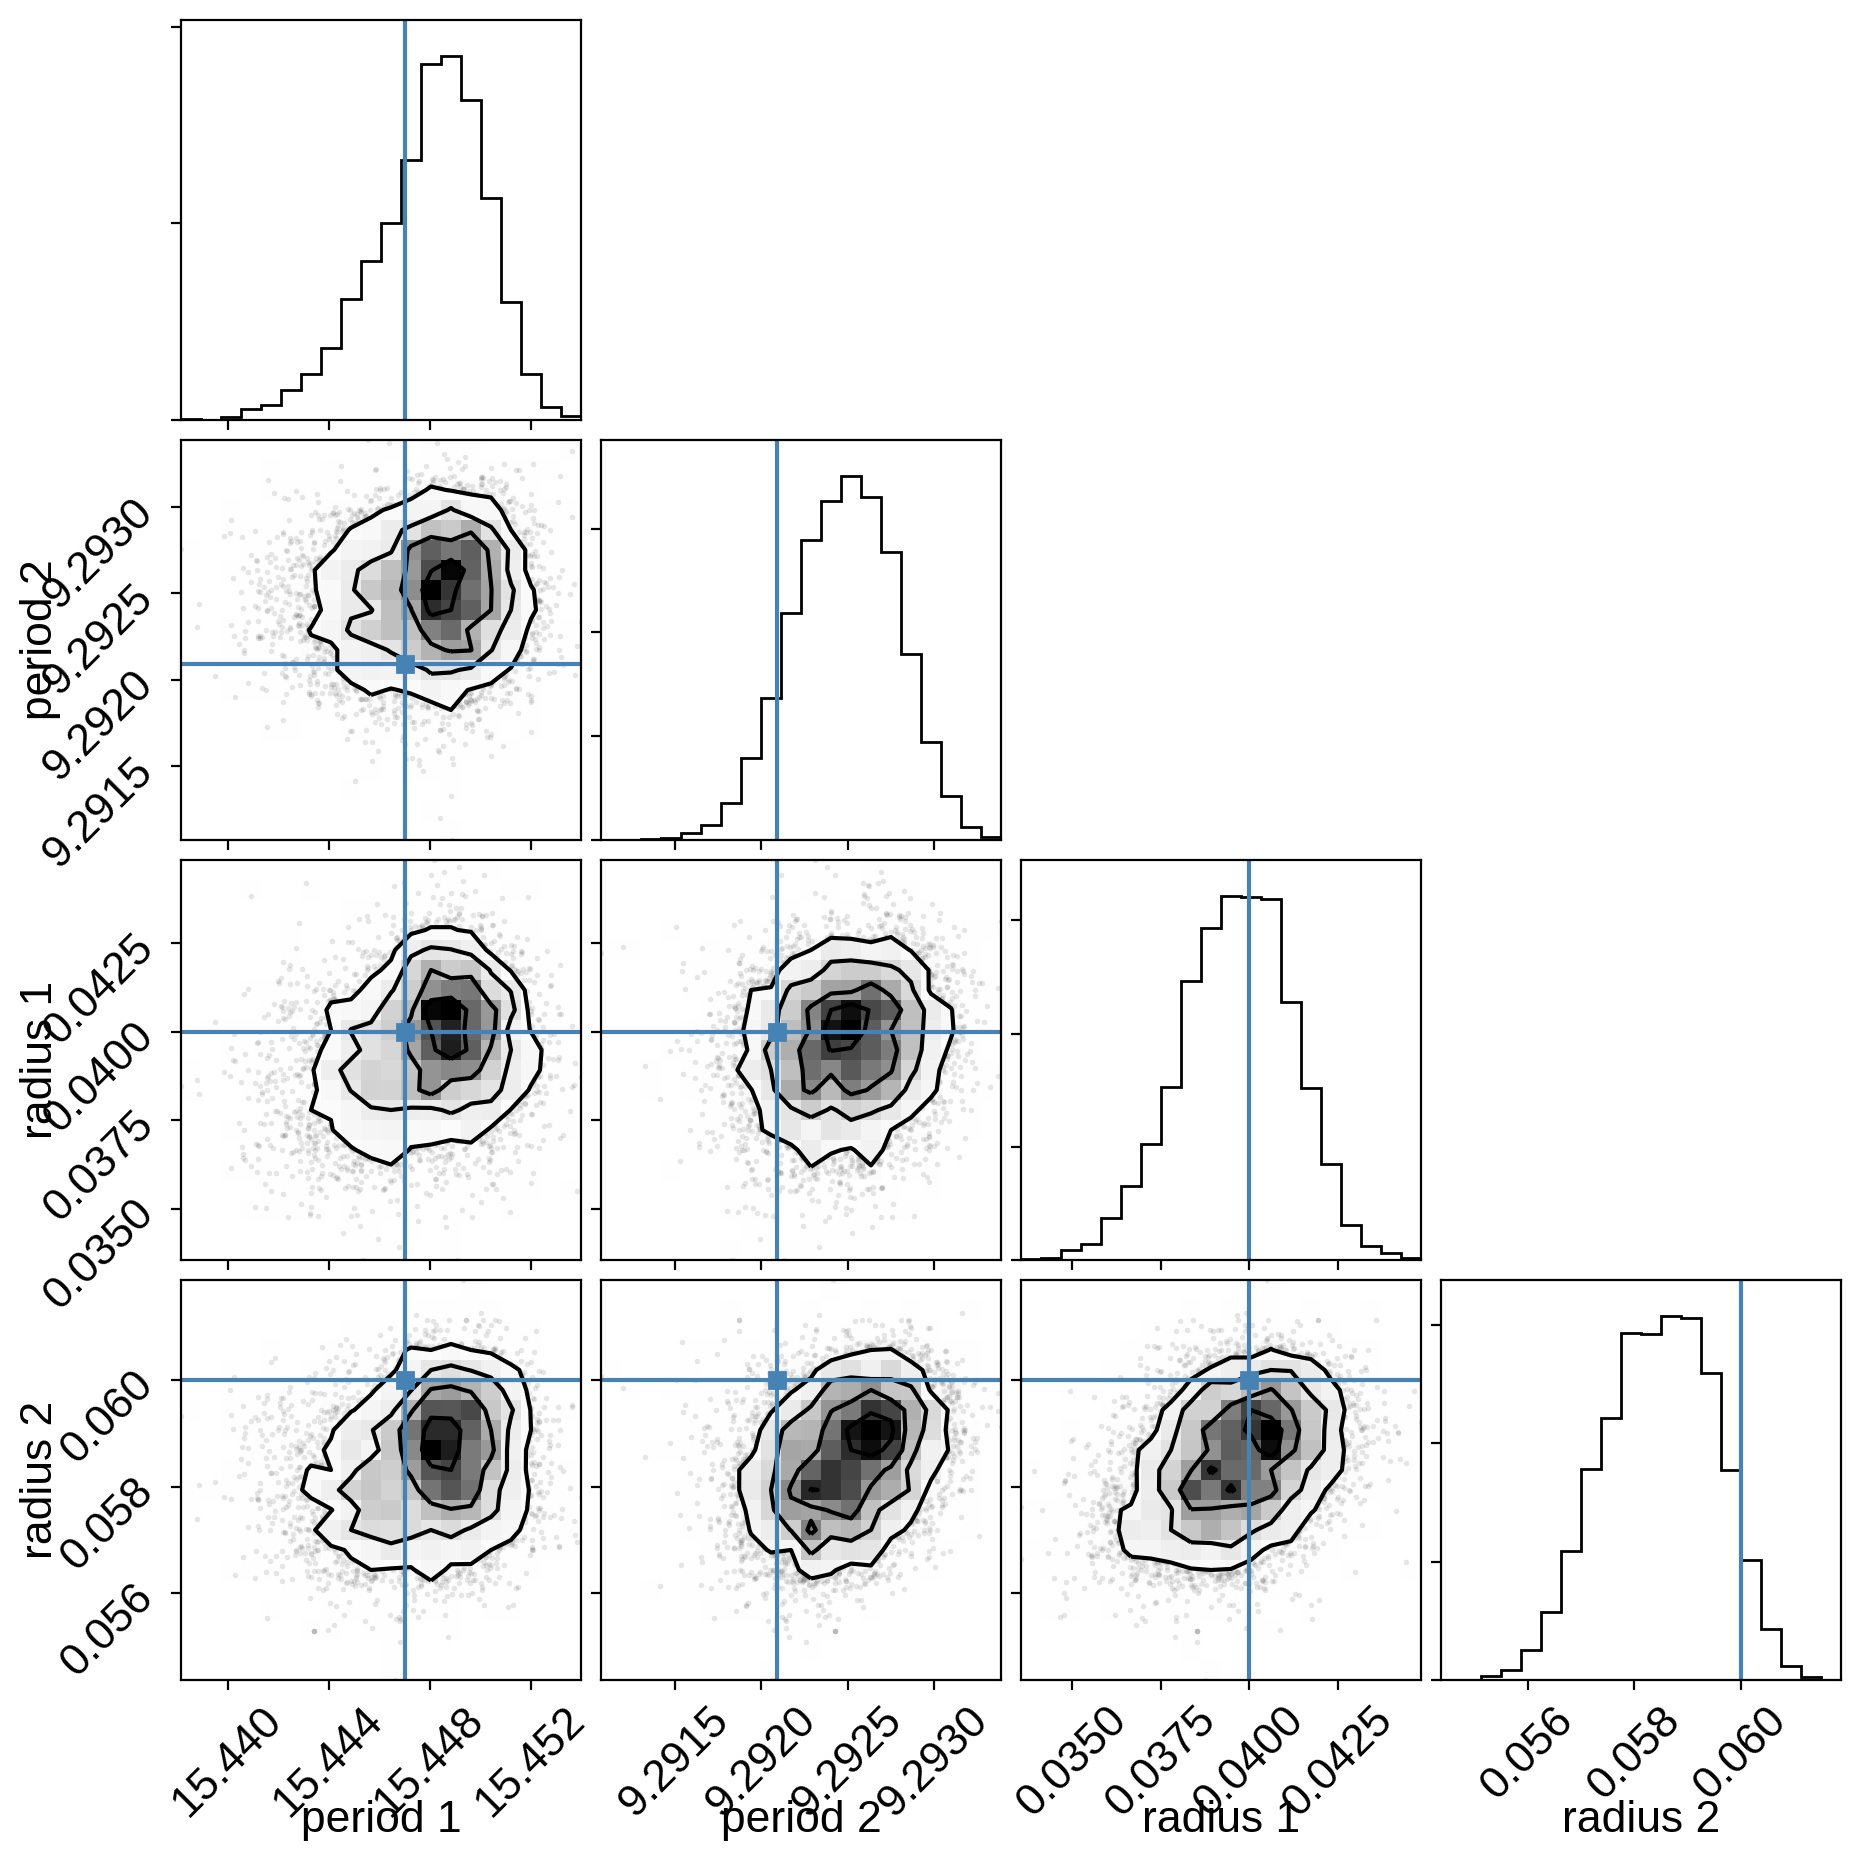

In [9]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(
    xo.eval_in_model([period, r], model.test_point, model=model)
)
_ = corner.corner(
    samples,
    truths=truth,
    labels=["period 1", "period 2", "radius 1", "radius 2"],
)

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

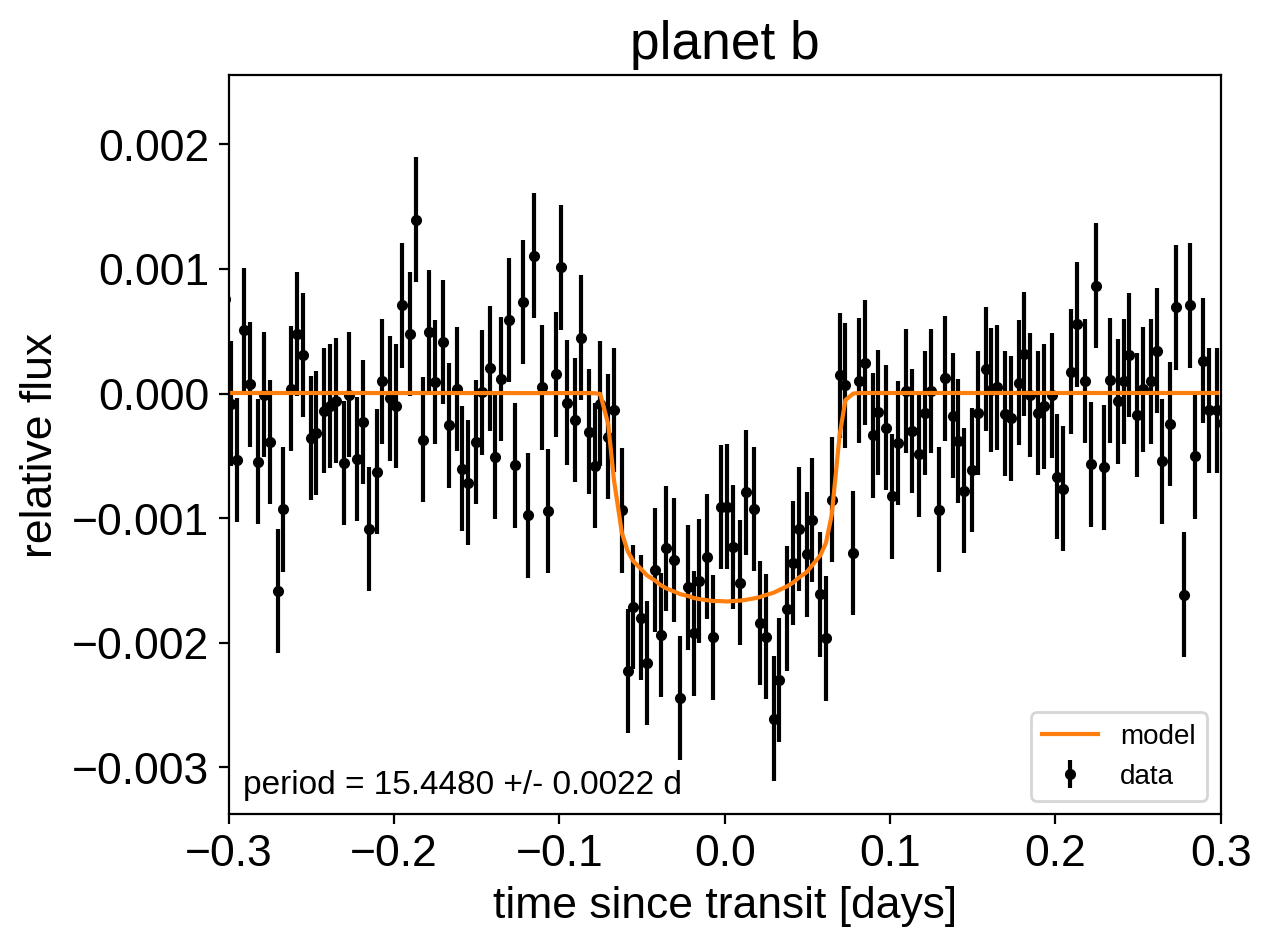

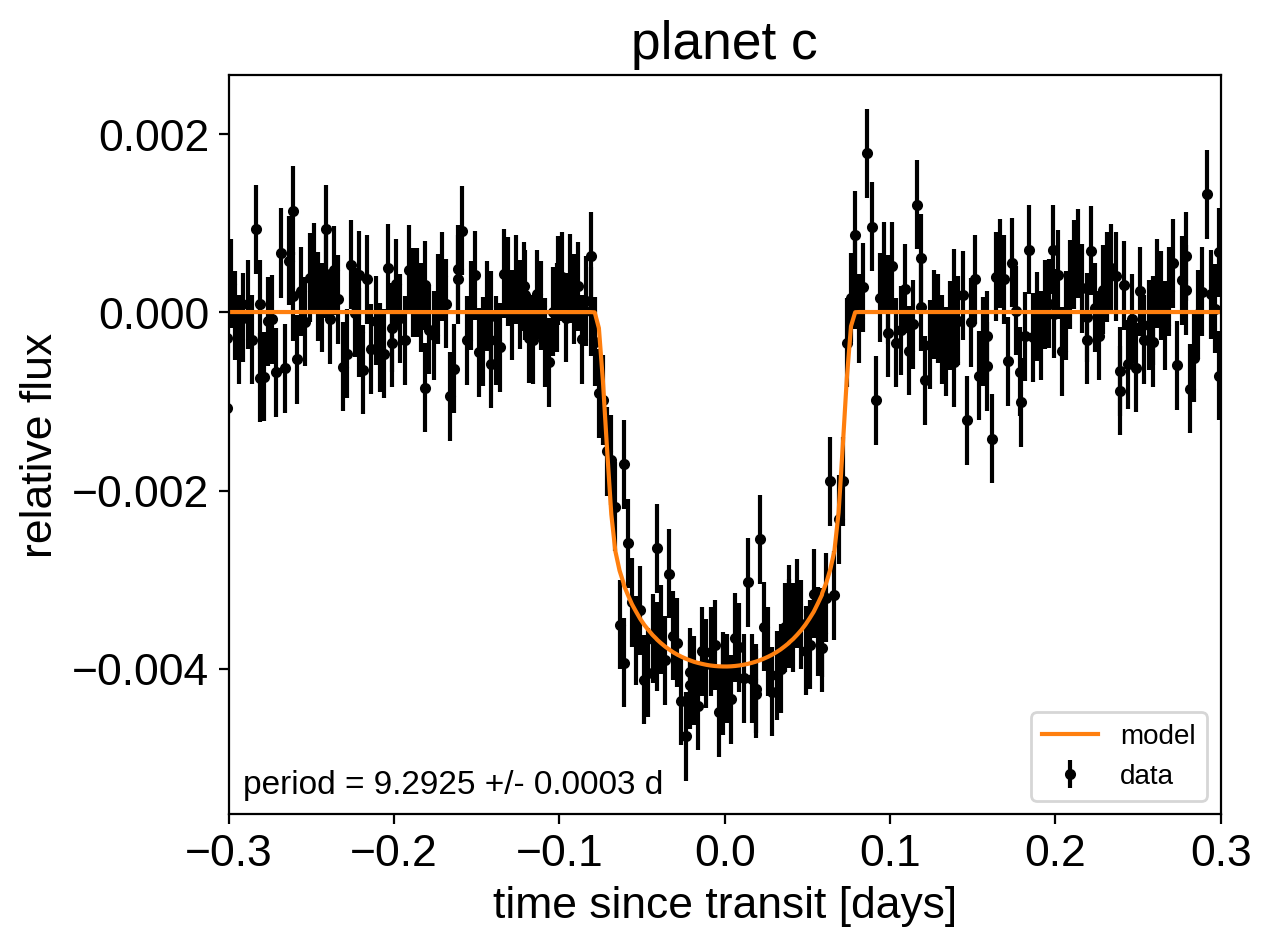

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.1},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
